In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import Series,DataFrame
from numpy import nan as NaN

%load_ext autoreload
%autoreload 2

In [2]:
df_ABC_distance = pd.read_excel('data/DZDB4.xlsx',sheet_name="Samples")
df_Data = pd.read_excel('data/DZDB4.xlsx',sheet_name="UPb_Data")
df_ABC_distance = df_ABC_distance.rename(columns={'distance_subduction':'distance'})
SedimentaryZircon = pd.merge(df_ABC_distance,df_Data,on='Ref_Sample_Key')

dataframe_age0 = df_ABC_distance[df_ABC_distance['Est. Depos. Age (Ma)'] == 0]
dataframe_age1 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] > 0 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 100)]
dataframe_age01 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] >= 0 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 100)]
dataframe_age2 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] > 100 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 200)]
dataframe_age3 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] > 200 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 300)]
dataframe_age4 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] > 300 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 410)]

In [3]:
dataframe_age01['distance'].max()

6014.69237845468

In [8]:
dataframe_age01['distance'].max()

6014.69237845468

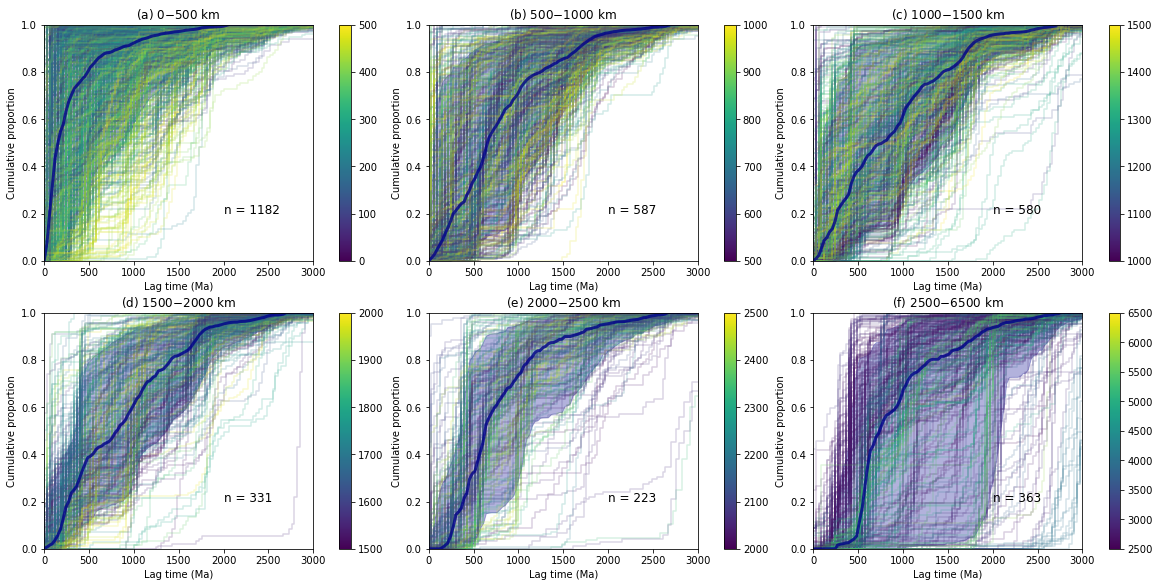

In [6]:
#from scipy.interpolate import make_interp_spline
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,8), constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
no_texts = ['(a) ','(b) ','(c) ','(d) ','(e) ','(f) ']
min_distances = np.arange(0,3000,500)
for i,min_distance in enumerate(min_distances):
    if min_distance != 2500:
        max_distance = min_distance + 500
    else:
        max_distance = min_distance + 4000
        
    df_new = dataframe_age01[np.logical_and(dataframe_age01['distance'] >= min_distance, dataframe_age01['distance'] < max_distance)]
    
    norm = mpl.colors.Normalize(vmin=min_distance, vmax=max_distance)
    cmap = plt.cm.viridis
    
    Sample_Key = df_new['Ref_Sample_Key']
    Sample_Key = Sample_Key.to_list()
    data = []
    count = 0
    ax = fig.add_subplot(gs[i])
    for ii, key_i in enumerate(Sample_Key):
        Sample_age = SedimentaryZircon[SedimentaryZircon['Ref_Sample_Key'] == key_i]
        
        age_list = []
        for ii in Sample_age.index.values:
            if ~np.isnan(Sample_age.loc[ii,'Published 206Pb/238U age (Ma)']):
                age = Sample_age.loc[ii,'Published 206Pb/238U age (Ma)']
            else:
                age = Sample_age.loc[ii,'Published 207Pb/206Pb age (Ma)']
            age_list.append(age)
        CA_DA = age_list - Sample_age['Est. Depos. Age (Ma)']     
    
        CA_DA.dropna(inplace=True)
        if CA_DA.shape[0]>0:
            ecdf = sm.distributions.ECDF(CA_DA)
            x = np.linspace(0, 3000, 100)
            y = ecdf(x)
            color = cmap(norm(Sample_age['distance'].iloc[0]))
            ax.step(x, y, color = color, alpha=0.2)
            data.append(y)
            #ax.set_title('ww')
            ax.set_xlabel('Lag time (Ma)')
            ax.set_ylabel('Cumulative proportion')
            ax.set_ylim(0,1)
            ax.set_xlim(0,3000)
            count = count + 1

    y2=np.quantile(data, 0.5, axis=0)
    ax.plot(x,y2, color = 'darkblue', alpha=0.8, linewidth = 3)
    ax.text(2000,0.2, 'n = '+str(count), horizontalalignment='left', size='large', color='black')
    min_time = 0.1
    max_time = 0.9
    y3=np.quantile(data, min_time, axis=0)
    y4=np.quantile(data, max_time, axis=0)
    #ax.plot(x,y3, color = 'orange', alpha=1 , linewidth = 1, linestyle = '--')
    #ax.plot(x,y4, color = 'orange', alpha=1, linewidth = 1, linestyle = '--')
    ax.fill_between(x, y3, y4, color = 'darkblue', alpha=0.3)
    ax.set_title(no_texts[i]+str(min_distance)+'$-$'+str(max_distance)+' km')
    
    cbar_ax = mpl.colorbar.make_axes(ax)
    mpl.colorbar.ColorbarBase(cbar_ax[0], norm=norm, cmap=cmap)    
    
#plt.tight_layout()
fig.savefig('plots/figures/Figure5.pdf')    
fig.savefig('plots/figures/Figure5.png', dpi=600)
plt.show()    